In [163]:
# Numpy
import numpy as np
import scipy as sc

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse
from utils.sqrtm import sqrtm
from utils.utils import AverageMeter, DCN

In [219]:
def data_loader(file_num, batch_size):
    # (# of trajectories, length of trajectory, # of dimension)
    with open(f'./data/train/trj_{file_num}.npy', 'rb') as f:
        train_data = np.load(f)
    with open(f'./data/test/trj_{file_num}.npy', 'rb') as f:
        test_data = np.load(f)
        
    train_data = TensorDataset(torch.FloatTensor(train_data[:, :-1].reshape(-1, 2)), 
                               torch.FloatTensor(np.diff(train_data, axis=-2).reshape(-1, 2)))
    test_data = TensorDataset(torch.FloatTensor(test_data[:, :-1].reshape(-1, 2)), 
                              torch.FloatTensor(np.diff(test_data, axis=-2).reshape(-1, 2)))

    train_loader = DataLoader(
                train_data,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,

            )
    test_loader = DataLoader(
                test_data,
                batch_size=batch_size * 10,
                shuffle=False,
                pin_memory=True,
            )
        
    return train_loader, test_loader

<IPython.core.display.Javascript object>


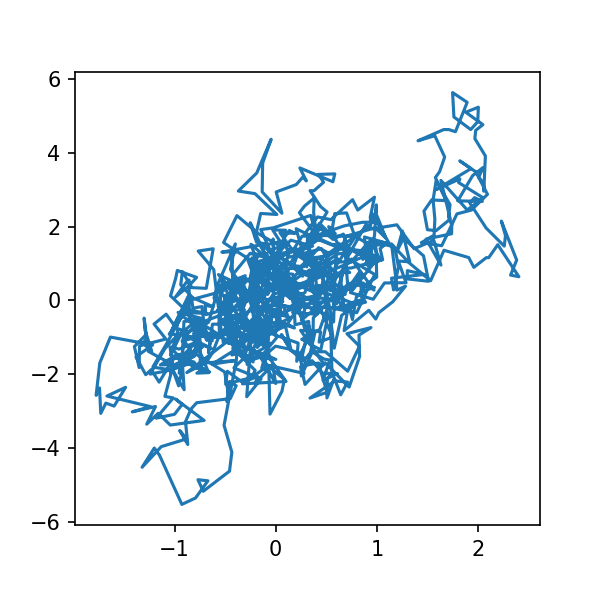

In [278]:
file_num = str(1)
# (# of trajectories, length of trajectory, # of dimension)
with open('./data/train/trj_'+ file_num + '.npy', 'rb') as f:
    train_data = np.load(f)
with open('./data/test/trj_'+ file_num + '.npy', 'rb') as f:
    test_data = np.load(f)
fig = plt.figure(figsize=(4, 4), dpi=150)
ax = fig.add_subplot(111)
n = 21
t = 1000
ax.plot(train_data[n][:t, 0], train_data[n][:t, 1])

In [262]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


class FieldLearning(nn.Module):
    def __init__(self, input_dim, output_dim, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        
        self.force_model = nn.Sequential(
            nn.Linear(input_dim, 256),            # [batch, 12, 16, 16]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, 256),           # [batch, 24, 8, 8]
            nn.ELU(),
            nn.Linear(256, output_dim),           # [batch, 48, 4, 4]
        )
        
        #x = np.ones((d, d))
        #y = sc.linalg.sqrtm(x)
        #self.diff_model = torch.nn.Parameter(torch.tensor(y))
        self.diag_ind = torch.stack([torch.arange(self.d), torch.arange(self.d)])
        self.off_diag_ind = torch.tril_indices(self.d, self.d, -1)
        self.diag_param = torch.nn.Parameter(torch.zeros(self.d))
        self.off_diag_param = torch.nn.Parameter(torch.zeros(int(self.d * (self.d - 1) / 2)))
        
        print(f"# of diag_param : {len(self.diag_param)}, # of off_diag_param : {len(self.off_diag_param)}")
        

    def forward(self, x):
        loc = self.force_model(x)
        scale_tril = torch.zeros(self.d, self.d).cuda()
        scale_tril[self.diag_ind[0], self.diag_ind[1]] = 1 + F.elu(self.diag_param)
        scale_tril[self.off_diag_ind[0], self.off_diag_ind[1]] = self.off_diag_param
        return loc * self.dt, scale_tril * torch.sqrt(self.dt)

In [284]:
# File setting
file_num = 1
data_dim = 2

# Create model
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
train_loader, test_loader = data_loader(file_num, batch_size=128)

# Define settings
epochs = 10000
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# of diag_param : 2, # of off_diag_param : 1


In [269]:
best_test_loss = np.inf

for epoch in range(epochs):
    train_losses = AverageMeter("TrainLoss")
    test_losses = AverageMeter("TestLoss")
    for data, labels in train_loader:
        loc, scale_tril = model(data.cuda())
        dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
        train_loss = - dist.log_prob(labels.cuda()).mean()
        train_loss.backward()
        optimizer.step()
        train_losses.update(train_loss.item(), data.shape[0])
        
    print(f'[Epoch {epoch}] Train loss :{train_losses.avg}')
    
    with torch.no_grad():
        for data, labels in test_loader:
            loc, scale_tril = model(data.cuda())
            dist = torch.distributions.MultivariateNormal(loc=loc, scale_tril=scale_tril)
            test_loss = - dist.log_prob(labels.cuda()).mean()
            test_losses.update(test_loss.item(), data.shape[0])

        print(f'[Epoch {epoch}] Test loss :{test_losses.avg}')
        is_best = test_losses.avg < best_test_loss
        
        if is_best or epoch == epochs - 1:
            best_test_loss = test_losses.avg
            print(f"save at epoch {epoch} : loss : {test_losses.avg}")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": test_loss,
                },
                f"./result/model/checkpoint_file{file_num}_{epoch}.pth",
            )

[Epoch 0] Train loss :94.80892383372858
[Epoch 0] Test loss :85.92924010311798
save at epoch 0 : loss : 85.92924010311798
[Epoch 1] Train loss :79.57529331735664
[Epoch 1] Test loss :73.60616348698468
save at epoch 1 : loss : 73.60616348698468
[Epoch 2] Train loss :68.72300214075973
[Epoch 2] Test loss :63.977623772509084
save at epoch 2 : loss : 63.977623772509084
[Epoch 3] Train loss :60.041641414583964
[Epoch 3] Test loss :56.18212882498882
save at epoch 3 : loss : 56.18212882498882
[Epoch 4] Train loss :52.91889093621276
[Epoch 4] Test loss :49.72055615893316
save at epoch 4 : loss : 49.72055615893316
[Epoch 5] Train loss :46.98336401334225
[Epoch 5] Test loss :44.2899018767691
save at epoch 5 : loss : 44.2899018767691
[Epoch 6] Train loss :41.97379604562019
[Epoch 6] Test loss :39.686153964517544
save at epoch 6 : loss : 39.686153964517544
[Epoch 7] Train loss :37.70077995841271
[Epoch 7] Test loss :35.723663567070815
save at epoch 7 : loss : 35.723663567070815
[Epoch 8] Train los

[Epoch 65] Test loss :1.4398879491969316
save at epoch 65 : loss : 1.4398879491969316
[Epoch 66] Train loss :1.419280059952082
[Epoch 66] Test loss :1.3930748653883982
save at epoch 66 : loss : 1.3930748653883982
[Epoch 67] Train loss :1.3743653183692048
[Epoch 67] Test loss :1.3499401001110471
save at epoch 67 : loss : 1.3499401001110471
[Epoch 68] Train loss :1.332563044450464
[Epoch 68] Test loss :1.3089037712412674
save at epoch 68 : loss : 1.3089037712412674
[Epoch 69] Train loss :1.2919804887116366
[Epoch 69] Test loss :1.2692978700455075
save at epoch 69 : loss : 1.2692978700455075
[Epoch 70] Train loss :1.253277872624022
[Epoch 70] Test loss :1.2329844291764076
save at epoch 70 : loss : 1.2329844291764076
[Epoch 71] Train loss :1.2171731541044462
[Epoch 71] Test loss :1.1963797248498311
save at epoch 71 : loss : 1.1963797248498311
[Epoch 72] Train loss :1.1826206701938504
[Epoch 72] Test loss :1.1629851969924851
save at epoch 72 : loss : 1.1629851969924851
[Epoch 73] Train loss

[Epoch 132] Test loss :0.6422610643995155
[Epoch 133] Train loss :0.6441261154695181
[Epoch 133] Test loss :0.6434928556229665
[Epoch 134] Train loss :0.645969419088563
[Epoch 134] Test loss :0.6462849696274579
[Epoch 135] Train loss :0.648075081627063
[Epoch 135] Test loss :0.648081282053319
[Epoch 136] Train loss :0.6503210800399135
[Epoch 136] Test loss :0.6504321095215964
[Epoch 137] Train loss :0.6527671982910839
[Epoch 137] Test loss :0.6529064070547757
[Epoch 138] Train loss :0.6551679111542803
[Epoch 138] Test loss :0.6558311256292713
[Epoch 139] Train loss :0.6578712122456314
[Epoch 139] Test loss :0.6588631950362777
[Epoch 140] Train loss :0.6607232326423541
[Epoch 140] Test loss :0.661289895322397
[Epoch 141] Train loss :0.6632782095460275
[Epoch 141] Test loss :0.6637053620017688
[Epoch 142] Train loss :0.6658889785803894
[Epoch 142] Test loss :0.6667056078421544
[Epoch 143] Train loss :0.6690183537563618
[Epoch 143] Test loss :0.6694465116603766
[Epoch 144] Train loss :0.6

[Epoch 229] Test loss :1.0910803398354934
[Epoch 230] Train loss :1.0942615781034013
[Epoch 230] Test loss :1.0967241734859408
[Epoch 231] Train loss :1.0997866159506422
[Epoch 231] Test loss :1.102288353224971
[Epoch 232] Train loss :1.1052106789429554
[Epoch 232] Test loss :1.107528343409559
[Epoch 233] Train loss :1.110715054373632
[Epoch 233] Test loss :1.1132216494516654
[Epoch 234] Train loss :1.1162178368834998
[Epoch 234] Test loss :1.1187315748910782
[Epoch 235] Train loss :1.121681342832636
[Epoch 235] Test loss :1.1241926609557775
[Epoch 236] Train loss :1.1270580580373062
[Epoch 236] Test loss :1.1293369794991126
[Epoch 237] Train loss :1.132491178277469
[Epoch 237] Test loss :1.1348383769832595
[Epoch 238] Train loss :1.1381548655420581
[Epoch 238] Test loss :1.140522345958656
[Epoch 239] Train loss :1.1434247049520894
[Epoch 239] Test loss :1.145779520297649
[Epoch 240] Train loss :1.1488901525793678
[Epoch 240] Test loss :1.151101584352962
[Epoch 241] Train loss :1.15421

[Epoch 327] Train loss :1.597733609662293
[Epoch 327] Test loss :1.6000711656854276
[Epoch 328] Train loss :1.6024986844254037
[Epoch 328] Test loss :1.6047176124787543
[Epoch 329] Train loss :1.6073530065270587
[Epoch 329] Test loss :1.609677061363153
[Epoch 330] Train loss :1.6121197281623914
[Epoch 330] Test loss :1.614208187509959
[Epoch 331] Train loss :1.616978209282186
[Epoch 331] Test loss :1.6189971654268966
[Epoch 332] Train loss :1.6217524865279496
[Epoch 332] Test loss :1.6238999288288853
[Epoch 333] Train loss :1.6265237856316608
[Epoch 333] Test loss :1.6287543723530526
[Epoch 334] Train loss :1.6312716791522253
[Epoch 334] Test loss :1.6334442051258882
[Epoch 335] Train loss :1.6360566650875712
[Epoch 335] Test loss :1.6385462417925867
[Epoch 336] Train loss :1.6408455186806294
[Epoch 336] Test loss :1.6429909485079597
[Epoch 337] Train loss :1.6455692357389387
[Epoch 337] Test loss :1.6476372118174571
[Epoch 338] Train loss :1.6503070418459616
[Epoch 338] Test loss :1.6

[Epoch 424] Train loss :2.0273681571934508
[Epoch 424] Test loss :2.029751774053214
[Epoch 425] Train loss :2.0322217399380853
[Epoch 425] Test loss :2.034405044818332
[Epoch 426] Train loss :2.037036135842626
[Epoch 426] Test loss :2.0393968621353253
[Epoch 427] Train loss :2.0419024326119595
[Epoch 427] Test loss :2.0441140048586615
[Epoch 428] Train loss :2.0466808167614094
[Epoch 428] Test loss :2.0489298521584183
[Epoch 429] Train loss :2.051523969346779
[Epoch 429] Test loss :2.0539477547045553
[Epoch 430] Train loss :2.056381153918729
[Epoch 430] Test loss :2.058600297500186
[Epoch 431] Train loss :2.0612161006063374
[Epoch 431] Test loss :2.063660350157292
[Epoch 432] Train loss :2.0660468169505246
[Epoch 432] Test loss :2.068314149449117
[Epoch 433] Train loss :2.070739347901579
[Epoch 433] Test loss :2.0731299710161677
[Epoch 434] Train loss :2.0755325394886137
[Epoch 434] Test loss :2.0777162765476604
[Epoch 435] Train loss :2.0802164854604204
[Epoch 435] Test loss :2.082478

[Epoch 522] Train loss :2.4600088692007094
[Epoch 522] Test loss :2.4619459829541226
[Epoch 523] Train loss :2.463987965336298
[Epoch 523] Test loss :2.4659672929926124
[Epoch 524] Train loss :2.467959674319597
[Epoch 524] Test loss :2.469852827105335
[Epoch 525] Train loss :2.47199353520519
[Epoch 525] Test loss :2.473972148491819
[Epoch 526] Train loss :2.4759273625154568
[Epoch 526] Test loss :2.477851357690357
[Epoch 527] Train loss :2.479887677865191
[Epoch 527] Test loss :2.4818085406038546
[Epoch 528] Train loss :2.483876965282702
[Epoch 528] Test loss :2.4858183140158117
[Epoch 529] Train loss :2.487867456183027
[Epoch 529] Test loss :2.4898609147881112
[Epoch 530] Train loss :2.4917944793937705
[Epoch 530] Test loss :2.493646198416343
[Epoch 531] Train loss :2.495766609289942
[Epoch 531] Test loss :2.4977362667707124
[Epoch 532] Train loss :2.499705556860351
[Epoch 532] Test loss :2.501601959178538
[Epoch 533] Train loss :2.5035833882498664
[Epoch 533] Test loss :2.50545301832

[Epoch 620] Train loss :2.820388176387066
[Epoch 620] Test loss :2.822047516722383
[Epoch 621] Train loss :2.82376143104232
[Epoch 621] Test loss :2.825472456603685
[Epoch 622] Train loss :2.827185452369967
[Epoch 622] Test loss :2.8288566080757778
[Epoch 623] Train loss :2.830525615149253
[Epoch 623] Test loss :2.8321593923775694
[Epoch 624] Train loss :2.833891213095919
[Epoch 624] Test loss :2.8355400799298147
[Epoch 625] Train loss :2.8372151222662017
[Epoch 625] Test loss :2.838847586869931
[Epoch 626] Train loss :2.8405662522152406
[Epoch 626] Test loss :2.842291846601042
[Epoch 627] Train loss :2.843945701663787
[Epoch 627] Test loss :2.8455224753928334
[Epoch 628] Train loss :2.8472574075053534
[Epoch 628] Test loss :2.8489381513520233
[Epoch 629] Train loss :2.850604346754408
[Epoch 629] Test loss :2.852289307476318
[Epoch 630] Train loss :2.8539559383613606
[Epoch 630] Test loss :2.855609829219082
[Epoch 631] Train loss :2.8572460033326332
[Epoch 631] Test loss :2.85886395315

KeyboardInterrupt: 

In [285]:
model = FieldLearning(input_dim=data_dim, output_dim=data_dim, d=data_dim, dt=0.001).cuda()
file_num = 1
epoch = 122
checkpoint = torch.load(f"./result/model/checkpoint_file{file_num}_{epoch}.pth",)
model.load_state_dict(checkpoint['model_state_dict'])

# of diag_param : 2, # of off_diag_param : 1


<All keys matched successfully>

In [272]:
%matplotlib notebook

In [276]:
xs = torch.linspace(-2, 2, steps=100)
ys = torch.linspace(-2, 2, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))

<IPython.core.display.Javascript object>


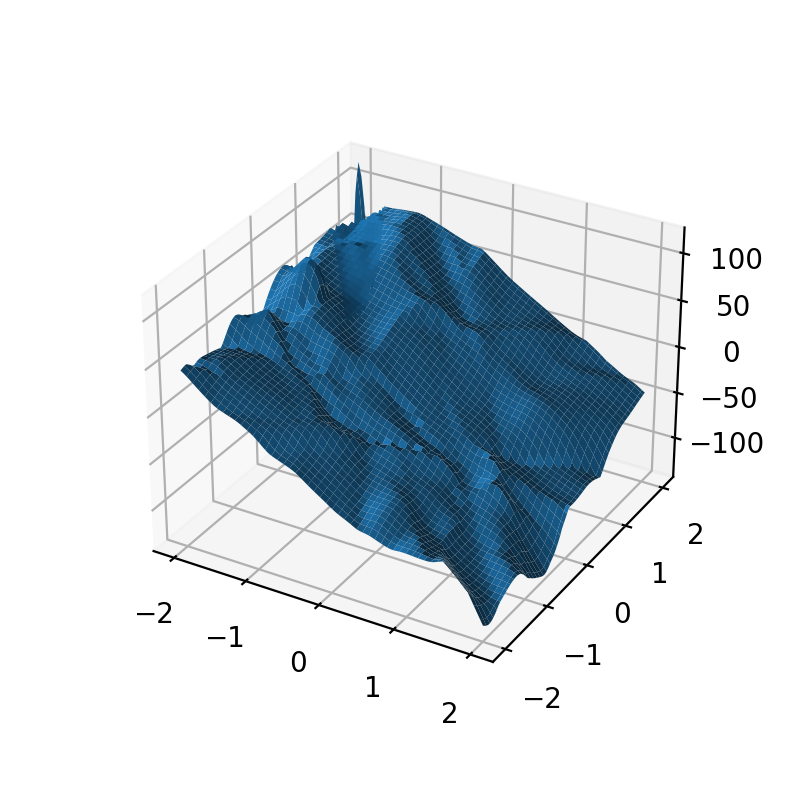

In [277]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 0]))

<IPython.core.display.Javascript object>


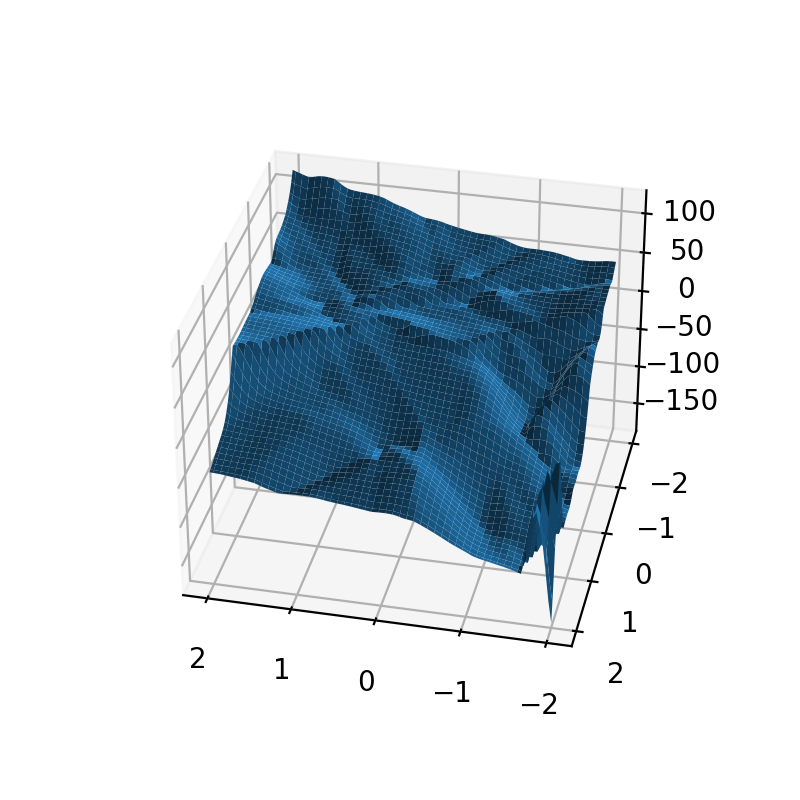

In [280]:
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), DCN(z[..., 1]))

<IPython.core.display.Javascript object>


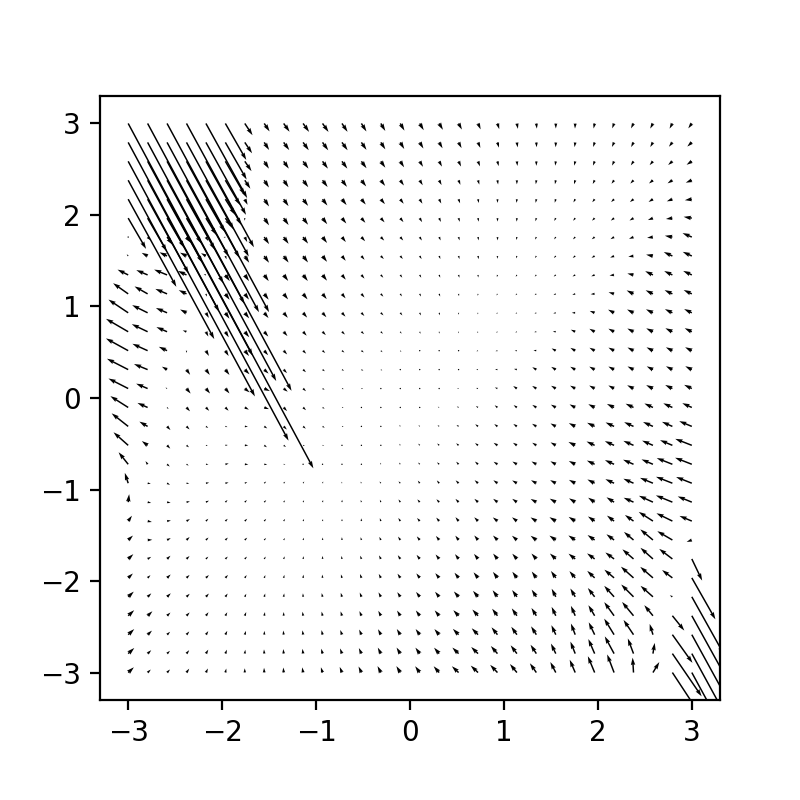

In [286]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
ax.quiver(x.numpy(), y.numpy(), DCN(z[..., 0]), DCN(z[..., 1]))

<IPython.core.display.Javascript object>


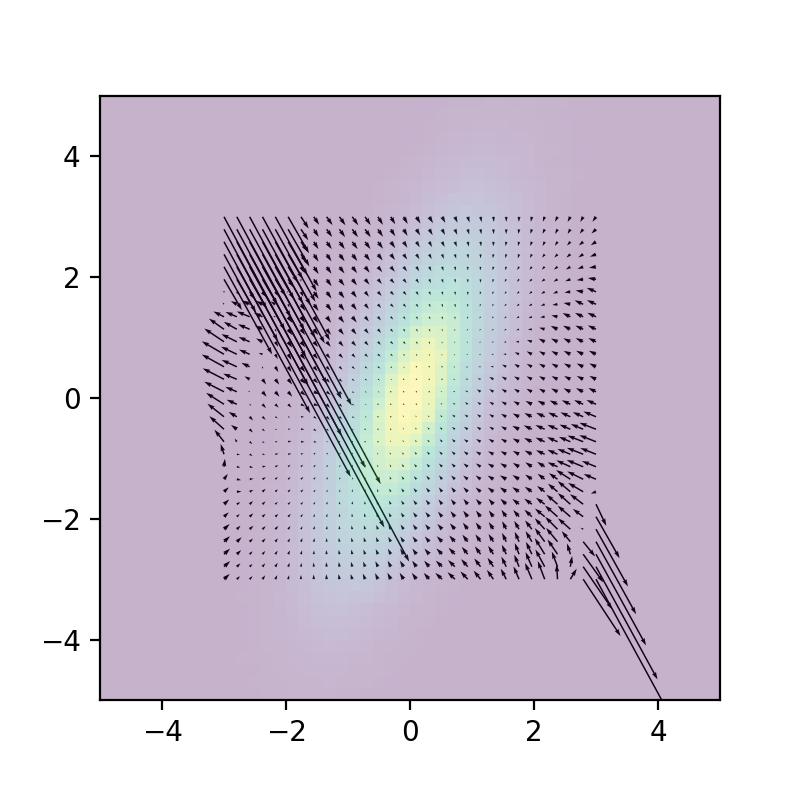

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 array([-5. , -4.8, -4.6, -4.4, -4.2, -4. , -3.8, -3.6, -3.4, -3.2, -3. ,
        -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. , -0.8,
        -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,
         1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,
         3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <matplotlib.collections.QuadMesh at 0x1eca0829048>)

In [291]:
xs = torch.linspace(-3, 3, steps=30)
ys = torch.linspace(-3, 3, steps=30)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = model.force_model(torch.cat((x.unsqueeze(-1).cuda(), y.unsqueeze(-1).cuda()), dim=-1))
fig = plt.figure(figsize=(4,4), dpi=200)
ax = fig.add_subplot(111)
ax.quiver(x.numpy(), y.numpy(), DCN(z[..., 0]), DCN(z[..., 1]))
ax.hist2d(train_data.reshape(-1, data_dim)[:, 0], train_data.reshape(-1, data_dim)[:, 1], bins=50, alpha=0.3, range=[[-5, 5],[-5, 5]]) 

In [282]:
scale_tril = torch.zeros(model.d, model.d).cuda()
scale_tril[model.diag_ind[0], model.diag_ind[1]] = 1 + F.elu(model.diag_param)
scale_tril[model.off_diag_ind[0], model.off_diag_ind[1]] = model.off_diag_param
diff_matrix = torch.matmul(scale_tril, scale_tril.T)
print(diff_matrix)

tensor([[111.9422,   1.5764],
        [  1.5764, 111.9798]], device='cuda:0', grad_fn=<MmBackward0>)


## ETC

In [ ]:
# Set random seed for reproducibility
SEED = 2589
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

    
class FieldLearning(nn.Module):
    def __init__(self, d, dt):
        super(FieldLearning, self).__init__()
        self.d = d  # space dimension
        self.dt = torch.tensor(dt)
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.force_model = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),

        )
        self.diff_model = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        force = force_model(x)
        diff_matrix = diff_model()
        dx = force * self.dt + sqrtm(2 * diff_matrix) * torch.normal(mean=torch.zeros(self.d), std=torch.ones(self.d)) * torch.sqrt(self.dt)
        return dx